# Chapter 2: Simulating Stochastic Rainfall Processes <a name="top"></a>

<div class="alert alert-info">
 [⬅️ Previous Chapter](Chapter%201.ipynb)     [➡️ Next Chapter](Chapter%203.ipynb)
</div>

![](../assets/kenya_rainfall.png)

In this chapter, we will use some of the principles and code introduced in Chapter 1 to develop a very simple model of daily rainfall. We will be able to use this model to simulate many seasons of daily rainfall that we can analyze. In addition, we will use actual rainfall data collected in Laikipia, Kenya to estimate the parameters of our model. This will allow us to simulate how rainfall variability and farmer decision making interact to affect food security outcomes in the next chapter.

## Chapter Objectives

* Develop a simple model of growing season daily rainfall
* Use the model to examine variability in growing season rainfall
* Extract model parameters from long-term rainfall data collected in Laikipia, Kenya
* Use the model to generate realizations of rainfall under altered climates
* Examine the impact of changing model parameters on rainfall variability 


In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Part 1. Modeling rainfall

Let's make a very simple model of rainfall that assumes a poisson process (i.e. memoryless). In the last chapter, we saw that this approach is probably too simple, and later we will look at how we could improve the model. But it helps to start with the most simple approach and then add complexity as needed.

Our model will be built with the following assumptions:

1. The probability of an "event" (i.e. rainfall) occuring on any given day is given by the parameter $\lambda_r$, which has units day$^{-1}$

2. The total depth of rainfall on days with rain is a random variable, drawn from an exponential distribution with mean, $\alpha$, which has units of mm.

This type of model is a ["marked poisson process"](http://www.math.kit.edu/stoch/~last/seite/lectures_on_the_poisson_process/media/lastpenrose2017.pdf) and is a special case of a poisson process on a number line (in our case, the number line is time), where each event is characterized by a random "mark" that is independent of the event.

### Step 1. Simulating poisson events

We have a variety of means to simulate a poisson process, and all of them will require the use of a random number generator. The `numpy` package has lots of different builtin functions to generate pseudo-random numbers, and we can use one of these. 

To simulate the likelihood of a poisson event, we can draw a sample from a uniform distribution in $[0,1]$ and compare that to our probability of an event. If the value we draw is less than or equal to our probability, then an event occurs, otherwise no event occurs. The probability density function, $f(x)$ of a uniform distribution sampled over the half open interval from $a$ to $b$, $[a,b)$ is given by 

$$
f(x) = \frac{1}{b - a}
$$


We can sample from this distribution using the [**numpy.random.uniform()**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.uniform.html) function:

```python

s = np.random.uniform(low=0,high=1)

```

The **np.random.uniform()** function also takes the optional argument `size`, which specifies the number of random samples to return. This allows for the generation of large lists of random samples without using a `for` loop or list comprehension approaches.

```python

s = np.random.uniform(low=0, high=1, size=2) # Returns an array of 2 random draws.

s_mat = np.random.uniform(low=0, high=1, size=[2, 10]) # Returns an array of 2 rows each with 10 random draws.


```

<div class="alert alert-success">✏️ **DIY Coding**: Using a $\lambda_r$ value of `0.15`, and assuming that the length of a growing season, $T_{seas}$, is 120 days, simulate a season of rainfall "events", where the value of a day is `1` if rainfall occurs, and `0` if not.</div>

<div class="alert alert-info">💡 You can use the **astype()** command to force Boolean (`True`/`False`) values into integers (`1`,`0`)</div>

In [362]:
# This cell intentionally left blank.

### Step 2. Adding marks to events

Our approach for creating marks (i.e. daily rainfall depths) is to sample them randomly from an exponential distribution with mean $\alpha$. The exponential probability density function $f(x)$ for $x\gt0$ as a function of $\alpha$ is expressed as 

$$
f(x) = \frac{1}{\alpha} \exp\left(-\frac{x}{\alpha}\right),
$$

Just as with sampling from a uniform distribution (and as with most everything in `python/pandas`), there's a **function** for that. In this case, we are going to use the... you guessed it... [**np.random.exponential()**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.exponential.html) function. It is used similarly to the **np.random.uniform()** function, but with a single parameter to describe the distribution:

```python

s = np.random.exponential(scale=11.5)  

```

The `scale` parameter is the mean of the distribution, which in our simulations will be $\alpha$ (mm), the average rainfall depth on days with rain. Just as with **np.random.uniform()**, we can generate lists or arrays of samples from the exponential distribution.

```python

s = np.random.exponential(scale=11.5, size=2) # Returns an array of 2 random draws.

s_mat = np.random.uniform(scale=11.5, size=[2, 10]) # Returns an array of 2 rows each with 10 random draws.

```
<div class="alert alert-success">✏️ **DIY Coding**: Assuming an average storm depth of `11.5 (mm)` and the samne $\alpha$ and $T_{seas}$ as before, generate a season of rainfall.</div>

<div class="alert alert-info">💡 The product of `0` and any rainfall amount is still `0`. That means you don't need to worry about which days have rain and which don't when multiplying a list of `rainfall_amounts` and a binary list of `rain_days`.</div>

In [363]:
# This cell intentionally left blank

<div class="alert alert-success">✏️ **DIY Coding**: Using the same $\lambda_r$, $\alpha$, and $T_{seas}$, do the following:</div>

1. Generate 100 seasons of rainfall
2. Plot a histogram of the seasonal totals
3. Calculate the $\widehat{CV}$ of seasonal rainfall.



In [364]:
# This cell intentionally left blank

# Part 2. Estimate model parameters from empirical data

We actually introduced most of the code necessary to determine model parameters from our rainfall data in the previous chapter. In order to have a little more fun, we're bringing in a much larger dataset of stations from around Laikipia county, Kenya. These stations span a fairly large range of annual rainfall and therefore provide a nice testbed for thinking about climate variability and agriculture. As we develop our analyses, we'll write code in a way that makes it easy to switch between stations and see how our results vary across the region.

## Reading in the rainfall dataset.

After reading in the data, where going to use some built-in `pandas` and `python` functions for manipulating `DateTime` objects. These functions will:

1. **Convert text strings** contained in the `RDate` column into `DateTime` objects. We will do this using a `format` string that defines the structure of the dates as they are represented in `RDate`. The function that we will use to do the conversion is the `pandas` builtin function called **to_datetime()**.

2. **Reassign date values** for dates from the first half of the 20th century, that **to_datetime()** mistakenly thinks are for the first half of the _21st_ century. This happens because our data represented years with two digits instead of four. **Note:** This is the ["Y2K problem"](https://en.wikipedia.org/wiki/Year_2000_problem) that many of you probably haven't heard of but briefly had people worrying that planes would fall from the skies on Jan 1, 2000.

<div class="alert alert-warning">🗓️ **Bottom Line:** Dealing with dates and times is always difficult! Always check to make sure things look correct after any conversion. And don't be afraid to ask/look for help!</div>

3. Extract new columns from our corrected `DateTime` objects that represent the `Year` and `Month` and save them into the `DataFrame`.

4. Assign our corrected `DateTime` values as the `index` of the dataframe, which means that instead of storing data by "row number", data will be stored according to unique date values. 

<div class="alert alert-warning">🗂️ When specifying an `index` column in `pandas`, it's necessary that the index is unqiue for each row of data. If we had multiple rows with the same date, this would not work.</div>

5. Delete the original `RDate` column, which we no longer need. This isn't strictly necessary, but it's just good hygenie to clean up `DataFrames` as much as possible. And we can always re-import the original `.csv` file if we needed to get at `RDate` again.

<div class="alert alert-info">💡 When doing complicated, multi-step transformations, it's good practice to itemize each step in a `markdown` cell before the `code` cell, and to match your code comments to the itemized list.</div>


In [365]:
from datetime import datetime
from dateutil.relativedelta import *

df = pd.read_csv("../data/CETRAD_rainfall.csv")  # Read in the raw csv data.

# Step 1. Convert text strings into datetime objects.
format = '%m/%d/%y' # Column RDate has data in M/D/YY
df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

# 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
# Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
# We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
# their value. This requires using the relativedelta function, which handles weird stuff like leap years.
df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

# Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
df['Year'] = [dt.year for dt in df['Datetime']]
df['Month'] = [dt.month for dt in df['Datetime']]

# Step 4. Use the Datetime values as the index for this dataframe.
df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

# Step 5.  Delete the old RDate column, which we no longer need. 
# We will keep the Datetime column, in case we need it later.
df = df.drop(['RDate'], axis=1)

Let's make sure all of these transformations worked.

In [366]:
df.head()

,ARCHERS POST,ARDENCAPLE FARM,CASTLE FOREST STN,CHOGORIA FOREST STN,CHUKA FOREST STN,COLCHECCIO,DOL DOL DAO,EL KARAMA,EMBORI FARM,EMBU MET STN,...,SOUTH MARMANET FOREST STN,SUGUROI ESTATE,TELEKI (MT KENYA),TELESWANI (NRM),THARUA FARM,TIMAU MARANIA,TRENCH FARM,Datetime,Year,Month
Datetime,,,,,,,,,,,,,,,,,,,,,
1934-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-01,1934,1
1934-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-02,1934,1
1934-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-03,1934,1
1934-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-04,1934,1
1934-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-05,1934,1


Looks okay. There are a ton of `NaN` values because only one or two stations have data in the 1930s. Let's look at the most recent data.

In [367]:
df.tail()

,ARCHERS POST,ARDENCAPLE FARM,CASTLE FOREST STN,CHOGORIA FOREST STN,CHUKA FOREST STN,COLCHECCIO,DOL DOL DAO,EL KARAMA,EMBORI FARM,EMBU MET STN,...,SOUTH MARMANET FOREST STN,SUGUROI ESTATE,TELEKI (MT KENYA),TELESWANI (NRM),THARUA FARM,TIMAU MARANIA,TRENCH FARM,Datetime,Year,Month
Datetime,,,,,,,,,,,,,,,,,,,,,
2016-11-27,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-27,2016,11
2016-11-28,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-28,2016,11
2016-11-29,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-29,2016,11
2016-11-30,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-30,2016,11
2016-12-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-01,2016,12


Again, we see that only a few stations have the most recent data. This is probably because they hadn't been coalated yet. In many places of Sub-Saharan Africa, it can take up to 5 years for rainfall data to get reported. 

Each column is a set of rainfall data for a specific location.

In [368]:
station_list = [station for station in df.columns if station not in ['Year', 'Day', 'Month', 'Datetime']]
print(station_list)

['ARCHERS POST', 'ARDENCAPLE FARM', 'CASTLE FOREST STN', 'CHOGORIA FOREST STN', 'CHUKA FOREST STN', 'COLCHECCIO', 'DOL DOL DAO', 'EL KARAMA', 'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM', 'GATHIURU FOREST STN', 'HOMBE FOREST STN', 'IRANGI FOREST STN', 'ISIOLO DAO', 'JACOBSON FARM', 'JUNCTION (EWASO NAROK)', 'KABARU FOREST STN', 'KAGURU', 'KALALU (NRM)', 'KAMWAKI FARM', 'KARURI (NRM)', 'KINAMBA MOW', 'KISIMA FARM', 'LAMURIA MET STN', 'LARIAK FOREST STN', 'LOGILADO (NRM)', 'LOLDAIGA FARM', 'LOLDOTO FARM', 'LOLMARIK FARM', 'LORUKU FARM', 'MARALAL DC', 'MARIENE CRS', 'MATANYA (NRM)', 'MERU FOREST STN', 'MOGWONI RANCH', 'MPALA FARM', 'MUGIE RANCH', 'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)', 'MURINGATO FOREST STN', 'MUTARA ADC FARM', 'MWEA IRRIGATION SCHEME', 'NANYUKI FOREST STN', 'NANYUKI KAF', 'NARO MORU FG POST', 'NARO MORU FOREST STN', 'NARO MORU GATE STN', 'NARO MORU MET STN', 'NDARAGWA FOREST STN', 'NGENIA (NRM)', 'NGENIA B', 'NICOLSON FARM', 'NYERI MOW', 'OL ARABEL FOREST STN

<div class="alert alert-warning">📍We won't do any mapping in this module. But, just in case, the geographhic locations for most of these stations are provided in the `../data/precipitation_gauge_locations.csv`. The coordinates in that file are in `UTM, Zone 37 North` projection, using the `Arc1960` projection.</div>

<div class="alert alert-success">✏️ **DIY Coding**: Determine the mean annual rainfall for each station</div>

<div class="alert alert-info">💡 Go back to Chapter 1 if necessary, and take a look at our good friend `groupby`. Also, don't forget about using `min_count` when doing sums to missing or under-reported years from your analyses.</div>

In [369]:
# This cell intentionally left blank

## Fitting rainfall depths to an exponential distribution

Our simple rainfall model makes two assumptions; (1) that events arrive according to a poisson process, and (2) that rainfall depths are distributed according to an exponential distribution. These two assumptions are accompanied by the need for two rainfall parameters; (1) the probability of rainfall events, $\lambda_r$, and the average depth of rainfall events $\alpha$. We've already seen how to estimate both of these parameters from rainfall data in `Chapter 1`, so here we are going to focus on testing the appropriateness of the model assumptions during the growing season for Laikipia, Kenya.

As an example, we're going to use the `JACOBSON FARM` data. It has a mean rainfall of about 750 mm and 83 years of data, so it's a good choice. Feel free to use another station. 

### Step 1. Filter data

In [408]:
station = 'JACOBSON FARM'
columns = [station] + ['Year', 'Month', 'Datetime']
rainfall = df[columns]
rainfall.head()

,JACOBSON FARM,Year,Month,Datetime
Datetime,,,,
1934-01-01,0.0,1934,1,1934-01-01
1934-01-02,0.0,1934,1,1934-01-02
1934-01-03,0.0,1934,1,1934-01-03
1934-01-04,0.0,1934,1,1934-01-04
1934-01-05,0.0,1934,1,1934-01-05


Let's take a quick look at the data

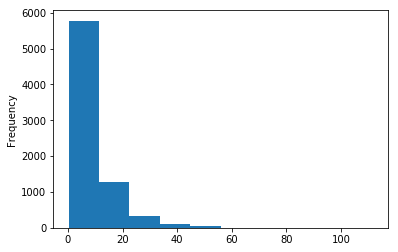

In [371]:
# Plot a histogram of rainfall values for days with rain.
daily_rainfall = rainfall.loc[rainfall[station] > 0][station]
daily_rainfall.plot.hist()

This looks okay, but we need to check and see how well the values in `daily_rainfall` fit our assumption of an exponential distribution.

### Step 2. Fit the distribution

To fit the distribution, we are going to use some more functions from `python`'s suite of numerical analysis. In this case we are going to use some functions from `scipy`. The [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) module has a large suite of distribution functions pre-defined, which we can use to develop a fit for our data. Using any of these distributions for fitting our data is very easy. The distribution we are most interested in is the exponential distribution, which is called `expon` in the `stats` module.

In [372]:
import scipy.stats as st

distribution = st.expon
data = daily_rainfall
params = distribution.fit(data, loc=0) # Force the distribution to be built off of zero

print(params)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

(0.2, 7.792004977595121)


### Step 3. Calculate fitted PDF and error with fit in distribution

To test the fit of our distribution, we can compare the empirical histogram to that predicted by our model. To do this, we first use our `data` to generate the empirical histogram. In this exampkle, we break the data into `30` bins, and we generate a histrogram of `density` rather than counts. This allows for an easier comparison between our empirical data and the fitted probability distribution function. Here are the steps:

1. Generate a histogram, from the `data`. Save the bin locations in `x` and the density of values in `y`
2. Shift the `x` bin locations generated from the histogram to the center of bins.
3. Calculate the value of the fitted `pdf(x)` for each of the bins in `x`.
4. Determine the residual sum of the squares, $SS_{error}$, and total sum of squares, $SS_{yy}$, according to:

$$ SS_{error} = \sum_{i=1}^{n} \left(y_i - f(x_i)\right)^2 $$
$$ SS_{yy} = \sum_{i=1}^{n} \left(y_i - \bar{y}\right)^2 $$

5. Calculate the $r^2$ of the fit, according to

$$ r^2 = 1- \frac{SS_{error}}{SS_{yy}} $$ 

 

In [373]:
# Step 1. Generate a density histogram of the data 
y, x = np.histogram(data, bins=30, density=True)

# Step 2. Shift the x bin locations to the center of bins.
x = (x + np.roll(x, -1))[:-1] / 2.0

# Step 3. Calculate the values of pdx(x) for all x.
pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

# Step 4. Determine the residual and total sum of the squares.
ss_error = np.sum(np.power(y - pdf, 2.0))
ss_yy = np.sum(np.power(y - y.mean(), 2.0))

r_2 = 1 - ( ss_error / ss_yy )
print(r_2)


0.9952863196308759


This is an extremely good fit, so we can be confident that our assumption about an exponential distribution of rainfall is reasonable.

## Determining monthly values of  $\lambda_r$ 

We did something very similar to this in `Chapter 1`. Basically, we need to determine the probability of rainfall for each month by dividing the number of rainy days per month by the total number of observations in each month. For now, we assume stationarity in the monthly values, which means that we are assuming that the values of $\lambda_r$ in each month are the same through out the entire record (i.e. Jan 1938 has the same properties as Jan 2008). 

<div class="alert alert-info">💡 It's worth thinking about how you could test our stationarity assumption. If you have an idea of how to do so, go ahead and give it a shot!</div>

As a first step, let's get all the `rain_days` and all of the `observation_days` from the data on `JACOBSON FARM`. We will use method chaining to run a **groupby()** as we go.

In [374]:
# First, find all the rows in the data where it rained and group by month.
rain_days = rainfall.loc[rainfall[station] > 0]

# Find all locations in the data where an observation was made.
all_days = rainfall.loc[rainfall[station] >= 0]

rain_days.head()

,JACOBSON FARM,Year,Month,Datetime
Datetime,,,,
1934-03-01,0.2,1934,3,1934-03-01
1934-03-18,0.5,1934,3,1934-03-18
1934-03-20,0.2,1934,3,1934-03-20
1934-03-22,6.3,1934,3,1934-03-22
1934-03-23,2.0,1934,3,1934-03-23


With these two sets of data and a list of months, we're ready to make our list of $\lambda_r$ values.

<div class="alert alert-info">💡We've often used `sum()` to add up all the values by month or by year. But you can also use the `count()` function to simply count the number of occurrences by month.</div>

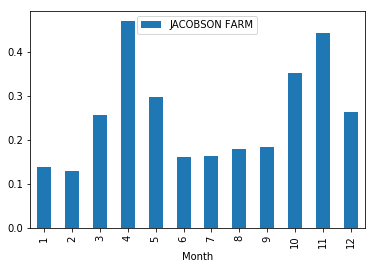

In [375]:
lambda_by_month = (
    rain_days.groupby('Month')[station].count() /
    all_days.groupby('Month')[station].count()
    )
pd.DataFrame(lambda_by_month).plot.bar()

## Simulating annual rainfall

To simulate annual rainfall, we are going to specify daily values of $\lambda_r$ using the monthly values we just calculated. The use of a variable $\lambda$ value in a poisson process creates what is known as an "inhomogenous poisson process" (or, alternatively, "nonhomogeneous"... unforatunetly, there isn't much homogeneity in what we call it!). These types of processes allow the properties of the process to change in space and time. Our implementation - using monthly values - is a little clunky, and we'd prefer to have the $\lambda$ values change more smoothly throughout the year. However, we probably don't have sufficient data to allow for this, even if we could accomodate the more complicated coding it would require. 

In order to generate our nonhomogenous process we will first generate a daily array of month numbers for the year `2018`. This is really easy in python using `datetime` + `timedelta` (which we need to import).

```python
    import datetime
    from datetime import timedelta
    datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
    month_value = np.array([datetime.month for datetime in datetimes])
```

In [670]:
from datetime import timedelta, datetime
datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
month_value_by_day = np.array([datetime.month for datetime in datetimes])

Now we have a 12-element `np.array` of $\lambda_r$ values, organized by month number:

In [377]:
print(lambda_by_month)

Month
1     0.138080
2     0.130397
3     0.258065
4     0.471605
5     0.299482
6     0.162140
7     0.164476
8     0.180406
9     0.184926
10    0.354042
11    0.445267
12    0.264436
Name: JACOBSON FARM, dtype: float64


And we have another `np.array` that specifies the month number for each day of the year: 

In [378]:
print(month_value_by_day)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11

`numpy` makes it really easy to map the values in one array onto the values of another.

```python
    lambda_values = [lambda_by_month[i] for i in month_value_by_day]
```

In [401]:
lambda_values = np.array([lambda_by_month[i] for i in month_value_by_day])

With daily values of $\lambda_r$, we only need to follow the same cookbook we used to make the seasonal data:

```python
    alpha = scale  # Let's use the value we estimated from our exponential fit.
    simulated_rainfall_values = np.random.exponential(
        scale=alpha, size=len(lambda_values)) # Use the len() function instead of a constant.
```

    

In [403]:
alpha = scale

simulated_rainy_days = (np.random.uniform(low=0, high=1, size=len(lambda_values)) <= lambda_values).astype(int)
simulated_rainfall_values = np.random.exponential(scale=alpha, size=len(lambda_values))

simulated_rainfall = simulated_rainy_days * simulated_rainfall_values

## Plotting our simulated data

We can easily plot our rainfall data using the `datetimes` object we already created as the basis of our x-axis.

<BarContainer object of 364 artists>

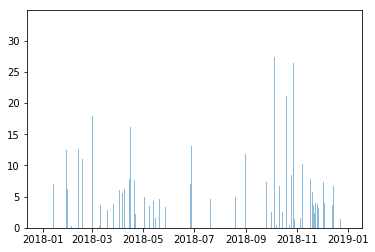

In [404]:
fig, ax = plt.subplots()

ax.bar(datetimes, simulated_rainfall, align='center', alpha=0.5)

<div class="alert alert-success">✏️ **DIY Coding**: Play around with our simulation. Here are a couple of ideas:</div>

1. Run 100 simulations of rainfall with our model for `JACOBSON FARM`. Compare the distribution of annual rainfall to the empirical distribution of annual rainfall.

2. Run the model for the same number of years that are in the `JACOBSON FARM` record and compare the mean and standard deviations of annual rainfall between the simulation and the empirical data. How well do they match?

2. Using the same simulations as in `2`, compare the mean and standard deviations of monthly rainfall between the simulation and the empirical data.

3. We've made $\lambda_r$ change every month, but we've used a constant $\alpha$ value. Determine if the assumption of a constant $\alpha$ is reasonable.

4. Determine the model parameters for a different station, preferably one with much lower or higher rainfall. How do the values of $\alpha$ and $\lambda_r$ change between stations?

5. Earlier I touched on the idea of non-stationarity in which the values of $\lambda_r$ and/or $\alpha$ may be changing over time. If you're up for it, see if you can come up with a way to investigate if our assumption of stationarity is valid.


In [667]:
# This cell intentionally left blank.

## ✅ End of Chapter 2

We're done with the second chapter. We've learned:

* How to draw random numbers from a uniform and exponential distributions
* How to use these numbers to simulate a marked poisson process
* How to work with `datetime` objects inside a `DataFrame`
* How to create a `DateTimeIndex` in a `DataFrame`
* How to fit a distribtion to a set of empirical data.
* How to test the fit of a distribution.
* How to create non-homogenous poisson processes.

## What's Next

Next we are going to explore daily data a little more and learn how to simluate rainfall as a stochastic process. We will also get to explore a much larger dataset of rainfall from the Laikipia region of Kenya, covering 80 stations and going back to 1934.

[Return to top](#top)